In [30]:
import glob
import os
import pandas as pd
import numpy as np
import stockDataHandler as sdh
import matplotlib.pyplot as plt
import matplotlib as mpl
# Regression Example With Boston Dataset: Baseline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import PReLU
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
seed = 7

# Path to Stock directory
pathStocks = "../Data/Stocks"
# Path to ETF directory
pathETFs = "../Data/ETFs"
# Path to additional data.
comp_data = "../Data/companies.csv"

stock_file_ext = "*.txt"

# Create list of all filenames to be imported
filenames = glob.glob(os.path.join(pathStocks, stock_file_ext))  # Create list of Stock filenames.
filenames += glob.glob(os.path.join(pathETFs, stock_file_ext))  # Concatenate the list of ETF filenames

# Import stocks and ETFs
print("Importing Stocks and ETFs from .txt files...")
stock_df = sdh.stock_dataframe(filenames, print_sample=5, print_dtypes=False, verbose=True, sort_index=True)
# Import supplemental data
print("Importing supplemental company metadata...")
comp_df = sdh.import_supp_data(comp_data)

print("Import complete.")

Importing Stocks and ETFs from .txt files...
No columns to parse from file: 'accp.us.txt' File may be blank.
No columns to parse from file: 'amrh.us.txt' File may be blank.
No columns to parse from file: 'amrhw.us.txt' File may be blank.
No columns to parse from file: 'asns.us.txt' File may be blank.
No columns to parse from file: 'bbrx.us.txt' File may be blank.
No columns to parse from file: 'bolt.us.txt' File may be blank.
No columns to parse from file: 'boxl.us.txt' File may be blank.
No columns to parse from file: 'bxg.us.txt' File may be blank.
No columns to parse from file: 'ehr.us.txt' File may be blank.
No columns to parse from file: 'fmax.us.txt' File may be blank.
No columns to parse from file: 'gnst.us.txt' File may be blank.
No columns to parse from file: 'hayu.us.txt' File may be blank.
No columns to parse from file: 'jt.us.txt' File may be blank.
No columns to parse from file: 'mapi.us.txt' File may be blank.
No columns to parse from file: 'molc.us.txt' File may be blank

In [3]:
# Example queries
print(comp_df.query('ticker == "tsco"'))
print(stock_df.query('Name == "tsco"'))

print(list(stock_df.columns.values))
print(list(comp_df.columns.values))

                  company_name              short_name  \
ticker                                                   
tsco    Tractor Supply Company  Tractor Supply Company   

                            industry  \
ticker                                 
tsco    Retail - Apparel & Specialty   

                                              description  \
ticker                                                      
tsco    Tractor Supply Co is an operator of rural life...   

                               website      logo                  ceo  \
ticker                                                                  
tsco    http://www.tractorsupplyco.com  TSCO.png  Gregory A. Sandfort   

                    exchange    market_cap             sector  \
ticker                                                          
tsco    Nasdaq Global Select  1.080913e+10  Consumer Cyclical   

                    tag_1             tag_2                         tag_3  
ticker                      

In [4]:
# Grab a subset of the tickers to process
tickers = np.unique([stock_df.index[i][0] for i in np.arange(0, 12000)])
tickers

# Get a survey of tickers
for ticker_name in tickers:
    print_out = "Ticker: {}, Date Min: {}, Date Max: {}"
    date_min = min(stock_df.query('Name == "{}"'.format(ticker_name)).index.get_level_values(1))
    date_max = max(stock_df.query('Name == "{}"'.format(ticker_name)).index.get_level_values(1))
    print(print_out.format(ticker_name, date_min, date_max))

Ticker: a, Date Min: 1999-11-18 00:00:00, Date Max: 2017-11-10 00:00:00
Ticker: aa, Date Min: 1970-01-02 00:00:00, Date Max: 2017-11-10 00:00:00


In [5]:
# Grab only those who have the same start and end dates.
tickers = np.array(['flic', 'iba', 'ncs'])
tickers

# Get a survey of tickers
for ticker_name in tickers:
    print_out = "Ticker: {}, Date Min: {}, Date Max: {}, Number of Entries: {}"
    date_min = min(stock_df.query('Name == "{}"'.format(ticker_name)).index.get_level_values(1))
    date_max = max(stock_df.query('Name == "{}"'.format(ticker_name)).index.get_level_values(1))
    nrows = len(stock_df.query('Name == "{}"'.format(ticker_name)).index)
    print(print_out.format(ticker_name, date_min, date_max, nrows))

Ticker: flic, Date Min: 2005-02-25 00:00:00, Date Max: 2017-11-10 00:00:00, Number of Entries: 3006
Ticker: iba, Date Min: 2005-02-25 00:00:00, Date Max: 2017-11-10 00:00:00, Number of Entries: 3199
Ticker: ncs, Date Min: 2005-02-25 00:00:00, Date Max: 2017-11-10 00:00:00, Number of Entries: 3201


In [6]:
flic_dates = stock_df.query('Name == "{}"'.format("flic")).index.get_level_values(1)
iba_dates = stock_df.query('Name == "{}"'.format("iba")).index.get_level_values(1)
ncs_dates = stock_df.query('Name == "{}"'.format("ncs")).index.get_level_values(1)

flic = stock_df.query('Name == "{}"'.format("flic"))
iba = stock_df.query('Name == "{}"'.format("iba"))
ncs = stock_df.query('Name == "{}"'.format("ncs"))

print(flic_dates)
shared_dates = np.intersect1d(np.intersect1d(flic_dates, iba_dates), ncs_dates)
print(len(shared_dates))

DatetimeIndex(['2005-02-25', '2005-02-28', '2005-03-01', '2005-03-02',
               '2005-03-03', '2005-03-04', '2005-03-07', '2005-03-08',
               '2005-03-09', '2005-03-10',
               ...
               '2017-10-30', '2017-10-31', '2017-11-01', '2017-11-02',
               '2017-11-03', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10'],
              dtype='datetime64[ns]', name='Date', length=3006, freq=None)
3005


In [7]:
feats = np.delete(flic.query('Date == "{}"'.format(shared_dates[0])).values, 3, 1)
labels = flic.query('Date == "{}"'.format(shared_dates[0])).values[:, 3]
print(feats.shape)
print(labels.shape)

feats = np.concatenate((feats, iba.query('Date == "{}"'.format(shared_dates[0])).values), 1)
feats = np.concatenate((feats, ncs.query('Date == "{}"'.format(shared_dates[0])).values), 1)
print(feats.shape)

for i in np.arange(1, len(shared_dates)):
    row = np.delete(flic.query('Date == "{}"'.format(shared_dates[i])).values, 3, 1)
    row = np.concatenate((row, iba.query('Date == "{}"'.format(shared_dates[i])).values), 1)
    row = np.concatenate((row, ncs.query('Date == "{}"'.format(shared_dates[i])).values), 1)

    feats = np.concatenate((feats, row))
    labels = np.concatenate((labels, flic.query('Date == "{}"'.format(shared_dates[i])).values[:, 3]))

print(feats.shape)
print(labels.shape)

(1, 5)
(1,)
(1, 17)
(3005, 17)
(3005,)


In [8]:
train_feats = feats[0:int(len(feats) * 0.75)]
test_feats = feats[int(len(feats) * 0.75):]
train_labels = labels[0:int(len(feats) * 0.75)]
test_labels = labels[int(len(feats) * 0.75):]

print(train_feats.shape)
print(test_feats.shape)
print(train_labels.shape)
print(test_labels.shape)

(2253, 17)
(752, 17)
(2253,)
(752,)


In [45]:
# model
def melissa_model():
    model = Sequential()
    model.add(Dense(10000, input_dim=17, activation='sigmoid'))
    model.add(Dense(1000, activation='sigmoid'))
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_absolute_percentage_error', optimizer='adam')

    return model

act = PReLU(weights=None, alpha_initializer="zero")
def connor_model():
    model = Sequential()
    model.add(Dense(10000, input_dim=17, activation='sigmoid'))
    model.add(PReLU(weights=None, alpha_initializer="zero", input_shape=(10000,1000)))
    model.add(act)
    model.add(act)
    model.add(act)
    model.compile(loss='mean_absolute_percentage_error', optimizer='adam')

    return model

# fit the keras model on the dataset
estimatorMelissa = KerasRegressor(build_fn=melissa_model, nb_epoch=1500, batch_size=100, verbose=True)
estimatorConnor = KerasRegressor(build_fn=connor_model, nb_epoch=1500, batch_size=100, verbose=True)

In [11]:
np.random.seed(seed)
historyMelissa = estimatorMelissa.fit(train_feats, train_labels, epochs = 100, validation_data = (test_feats, test_labels))

Train on 2253 samples, validate on 752 samples
Epoch 1/100
2253/2253 [==============================] - 1s 425us/step - loss: 79.7288 - val_loss: 88.5372
Epoch 2/100
2253/2253 [==============================] - 0s 90us/step - loss: 73.4651 - val_loss: 86.8585
Epoch 3/100
2253/2253 [==============================] - 0s 94us/step - loss: 70.4777 - val_loss: 85.6988
Epoch 4/100
2253/2253 [==============================] - 0s 91us/step - loss: 68.1389 - val_loss: 84.6435
Epoch 5/100
2253/2253 [==============================] - 0s 91us/step - loss: 65.8415 - val_loss: 83.5611
Epoch 6/100
2253/2253 [==============================] - 0s 91us/step - loss: 63.5114 - val_loss: 82.4923
Epoch 7/100
2253/2253 [==============================] - 0s 90us/step - loss: 61.2515 - val_loss: 81.4597
Epoch 8/100
2253/2253 [==============================] - 0s 91us/step - loss: 59.0547 - val_loss: 80.4542
Epoch 9/100
2253/2253 [==============================] - 0s 92us/step - loss: 56.9053 - val_loss: 79.463

2253/2253 [==============================] - 0s 97us/step - loss: 18.2811 - val_loss: 56.8809
Epoch 78/100
2253/2253 [==============================] - 0s 90us/step - loss: 18.2792 - val_loss: 56.8873
Epoch 79/100
2253/2253 [==============================] - 0s 90us/step - loss: 18.2792 - val_loss: 56.8812
Epoch 80/100
2253/2253 [==============================] - 0s 92us/step - loss: 18.2793 - val_loss: 56.8988
Epoch 81/100
2253/2253 [==============================] - 0s 97us/step - loss: 18.2811 - val_loss: 56.8567
Epoch 82/100
2253/2253 [==============================] - 0s 92us/step - loss: 18.2800 - val_loss: 56.8825
Epoch 83/100
2253/2253 [==============================] - 0s 96us/step - loss: 18.2792 - val_loss: 56.8866
Epoch 84/100
2253/2253 [==============================] - 0s 94us/step - loss: 18.2790 - val_loss: 56.8927
Epoch 85/100
2253/2253 [==============================] - 0s 91us/step - loss: 18.2803 - val_loss: 56.8750
Epoch 86/100
2253/2253 [==========================

In [12]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 100, 0, 100])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

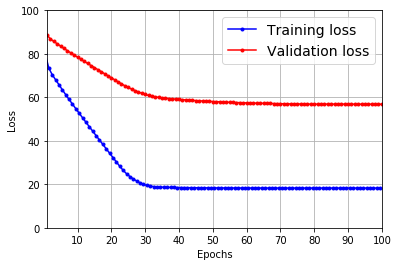

In [13]:
plot_learning_curves(historyMelissa.history["loss"], historyMelissa.history["val_loss"])
plt.show()

In [46]:
np.random.seed(seed)
historyConnor = estimatorConnor.fit(train_feats, train_labels, epochs = 100, validation_data = (test_feats, test_labels))

ValueError: Error when checking target: expected p_re_lu_10 to have shape (10000,) but got array with shape (1,)

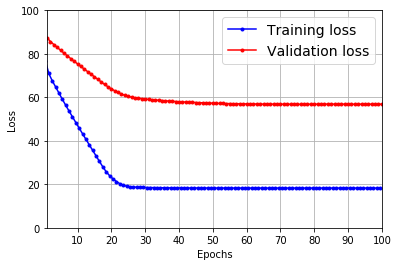

In [24]:
plot_learning_curves(historyConnor.history["loss"], historyConnor.history["val_loss"])
plt.show()